In [1]:
# TODO probably shouldn't be here
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# TODO probably shouldn't be here
!pip install traker

In [1]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from torch import nn as nn
from torchvision.datasets import Food101, ImageFolder
from trak import TRAKer
from trak import modelout_functions
from collections.abc import Iterable

from src.train import train_model
from src.early_stopping import EarlyStopping


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")

def preprocess_image(image):
    image = transforms.functional.pil_to_tensor(image)
    processed_image = processor.preprocess(image)["pixel_values"][0]
    return torch.from_numpy(processed_image)

num_classes = 10

train_dataset = Food101("data/food-101", split="train", transform=preprocess_image, download=False)
test_dataset = Food101("data/food-101", split="test", transform=preprocess_image, download=False)

In [3]:
filtered_dataset = ImageFolder("data/food-101/food-101/images", transform=preprocess_image)

# classes:
# bruschetta, garlic bread, grilled salmon, omelette, pancakes,
# pizza, porkchop, spaghetti bolognese, spaghetti carbonara, steak
chosen_indices = [10, 46, 50, 67, 72, 76, 77, 90, 91, 93]
new_class_idx_mapping = {k: v for k, v in zip(chosen_indices, range(num_classes))}

filtered_dataset.classes = [filtered_dataset.classes[i] for i in chosen_indices]
filtered_dataset.class_to_idx = {k: i for i, k in enumerate(filtered_dataset.classes)}

filtered_dataset.samples = list(filter(lambda s: s[1] in chosen_indices, filtered_dataset.samples))
filtered_dataset.samples = list(map(lambda s: (s[0], new_class_idx_mapping[s[1]]), filtered_dataset.samples))

filtered_train_subset, filtered_test_subset = torch.utils.data.random_split(filtered_dataset, [0.8, 0.2], torch.Generator().manual_seed(42))

train_dl = torch.utils.data.DataLoader(filtered_train_subset, batch_size=64, shuffle=True)
test_dl = torch.utils.data.DataLoader(filtered_test_subset, batch_size=64, shuffle=False)

print(len(filtered_dataset))

10000


In [4]:
model.classifier = nn.Sequential(
                    nn.Flatten(start_dim=1, end_dim=-1),
                    nn.Linear(in_features=512, out_features=num_classes))
for param in model.classifier.parameters():
        param.requires_grad = True

model.num_labels = num_classes

In [5]:
num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# baseline results - valid loss: 0.513, valid acc: 0.841
train_model(model, train_dl, test_dl, num_epochs, optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:22<00:00,  1.40it/s]


[Epoch 1] Loss: 0.903, Train Acc: 0.694,Valid loss: 0.555 Valid Acc: 0.818


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


[Epoch 2] Loss: 0.290, Train Acc: 0.919,Valid loss: 0.517 Valid Acc: 0.827


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]


[Epoch 3] Loss: 0.081, Train Acc: 0.990,Valid loss: 0.513 Valid Acc: 0.837


100%|██████████| 32/32 [00:35<00:00,  1.12s/it]


[Epoch 4] Loss: 0.027, Train Acc: 0.998,Valid loss: 0.516 Valid Acc: 0.834


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


[Epoch 5] Loss: 0.014, Train Acc: 0.999,Valid loss: 0.513 Valid Acc: 0.841


100%|██████████| 32/32 [00:21<00:00,  1.46it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.514 Valid Acc: 0.848


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


[Epoch 7] Loss: 0.005, Train Acc: 1.000,Valid loss: 0.527 Valid Acc: 0.841


100%|██████████| 32/32 [00:23<00:00,  1.35it/s]

[Epoch 8] Loss: 0.004, Train Acc: 1.000,Valid loss: 0.525 Valid Acc: 0.840
Early stopping at epoch 8


In [6]:
torch.save(model.state_dict(), "model_finetuned_baseline.pth")

In [5]:
#finetuned_path = '/content/drive/MyDrive/automating_science/model_finetuned_baseline.pth' #model_finetuned_baseline.pth
finetuned_path = "model_finetuned_baseline.pth"
checkpoint = torch.load(finetuned_path,  map_location=device)
model.load_state_dict(checkpoint)
model = model.to(device)

In [6]:
train_dl_no_shuffle = torch.utils.data.DataLoader(filtered_train_subset, batch_size=32, shuffle=False)
test_dl_no_shuffle = torch.utils.data.DataLoader(filtered_test_subset, batch_size=32, shuffle=False)

In [7]:
class ResNetOutput(modelout_functions.AbstractModelOutput):
    def __init__(self, loss_temperature: float = 1.0):
       super().__init__()
       self.softmax = nn.Softmax(dim=-1)
       self.loss_temperature = loss_temperature

    @staticmethod
    def get_output(
                model: torch.nn.Module,
                weights: Iterable[torch.Tensor],
                buffers: Iterable[torch.Tensor],
                image: torch.Tensor,
                label: torch.Tensor
      ):
      for key, value in weights.items():
        weights[key] = weights[key].to(device)
      output = torch.func.functional_call(model, (weights, buffers), image.unsqueeze(0))
      logits = output.logits #our change
      bindex = torch.arange(logits.shape[0]).to(logits.device, non_blocking=False)
      logits_correct = logits[bindex, label.unsqueeze(0)]

      cloned_logits = logits.clone()

      cloned_logits[bindex, label.unsqueeze(0)] = torch.tensor(-torch.inf, device=logits.device, dtype=logits.dtype)

      margins = logits_correct - cloned_logits.logsumexp(dim=-1)
      return margins.sum()
    
    def get_out_to_loss_grad(self, model, weights, buffers, batch):
      for key, value in weights.items():
        weights[key] = weights[key].to(device)
      images, labels = batch
      output = torch.func.functional_call(model, (weights, buffers), images)
      logits = output.logits #our change

      ps = self.softmax(logits / self.loss_temperature)[torch.arange(logits.size(0)), labels]
      return (1 - ps).clone().detach().unsqueeze(-1)

In [8]:
traker = TRAKer(model=model,
                task=ResNetOutput(),
                train_set_size=len(train_dl_no_shuffle.dataset))

ERROR:TRAK:Could not use CudaProjector.
Reason: No module named 'fast_jl'
ERROR:TRAK:Defaulting to BasicProjector.


INFO:STORE:No existing model IDs in C:\Users\kamil\OneDrive\Pulpit\przedmioty\semestr 8\automating science\trak-for-automating-science\trak_results.
INFO:STORE:No existing TRAK scores in C:\Users\kamil\OneDrive\Pulpit\przedmioty\semestr 8\automating science\trak-for-automating-science\trak_results.


In [10]:
model_id = 0
traker.load_checkpoint(checkpoint, model_id=0)

In [11]:
for data in tqdm(train_dl_no_shuffle):
    data = [xy.cuda() for xy in data]

    traker.featurize(batch=data, num_samples=data[0].shape[0])

  0%|          | 0/250 [00:00<?, ?it/s]c:\Users\kamil\anaconda3\envs\ml_gnn\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 250/250 [21:01<00:00,  5.04s/it]


In [12]:
traker.finalize_features()

Finalizing features for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


In [13]:
traker.start_scoring_checkpoint(exp_name="test_val", checkpoint=checkpoint, model_id=model_id, num_targets=len(test_dl_no_shuffle.dataset))
for batch in tqdm(test_dl_no_shuffle):
    batch = [xy.cuda() for xy in batch]
    traker.score(batch=batch, num_samples=batch[0].shape[0])

test_scores = traker.finalize_scores(exp_name="test_val")

 98%|█████████▊| 62/63 [46:18<00:45, 45.35s/it]c:\Users\kamil\anaconda3\envs\ml_gnn\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Finalizing scores for all model IDs..: 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]
INFO:STORE:Saving scores in C:\Users\kamil\OneDrive\Pulpit\przedmioty\semestr 8\automating science\trak-for-automating-science\trak_results\scores/test_val.mmap


In [14]:
test_scores.shape

(8000, 2000)

In [16]:
np.save("test_scores.npy", test_scores)

In [7]:
test_scores = np.load("test_scores.npy")

In [60]:
targets = []

for _, y in test_dl_no_shuffle:
    targets.extend(y.tolist())
targets = np.array(targets)

In [61]:
def compute_test_dataset_predictions(model, test_dl):
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in tqdm(test_dl):
            batch = [xy.cuda() for xy in batch]
            output = model(batch[0]).logits
            preds.extend(output.tolist())
    preds = torch.Tensor(preds)
    preds = torch.nn.functional.softmax(preds, dim=-1)
    return np.array(preds.tolist())


preds = compute_test_dataset_predictions(model, test_dl_no_shuffle)

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:31<00:00,  1.99it/s]


In [62]:
# https://openreview.net/pdf?id=Agekm5fdW3 - section 2.2
def compute_class_weights(preds, targets):
    class_weights = []
    for i in range(num_classes):
        n_elements = np.sum(targets == i)
        # added a minus sign to the whole expression inside exp, as I believe it's incorrect in the original paper
        # before, the classes with worse scores got lower weights, but it probably should be the opposite
        class_weights.append(np.exp(-1 / n_elements * np.sum(np.log(preds[targets == i][:, i]))))
    return np.array(class_weights)

class_weights = compute_class_weights(preds, targets)
class_weights

array([1.65128706, 1.94470773, 1.83594766, 1.96861238, 1.33618492,
       1.31584568, 3.12277379, 1.20719328, 1.11670319, 1.97544452])

In [63]:
# https://openreview.net/pdf?id=Agekm5fdW3 - section 2.2
def compute_class_alignment_scores(test_scores, targets, class_weights):
    group_alignment_scores = []
    n_train_examples = test_scores.shape[0]
    n_targets = []
    for i in range(num_classes):
        n_targets.append(np.sum(targets == i))
    n_targets = np.array(n_targets)
    for i in tqdm(range(n_train_examples)):
        example_score = 0.0
        for j in range(num_classes):
            scaling_factor = class_weights[j] / n_targets[j]
            example_score += scaling_factor * np.sum(test_scores[i, targets == j])
        group_alignment_scores.append(example_score)
    return np.array(group_alignment_scores)

group_alignment_scores = compute_class_alignment_scores(test_scores, targets, class_weights)
(group_alignment_scores < 0).sum()

100%|██████████| 8000/8000 [00:05<00:00, 1370.19it/s]


2888

In [64]:
# looking to remove only a small fraction of hopefully impactful examples
sorted_group_alignment_scores = np.sort(group_alignment_scores)
top_k_to_remove = 200
example_indices_to_keep = np.nonzero(~(group_alignment_scores < sorted_group_alignment_scores[top_k_to_remove]))[0]
len(example_indices_to_keep)

7800

In [14]:
train_data_after_trak = torch.utils.data.Subset(filtered_train_subset, example_indices_to_keep)
train_dl_after_trak = torch.utils.data.DataLoader(train_data_after_trak, batch_size=64, shuffle=True)

model_after_trak = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")
model_after_trak.classifier = nn.Sequential(
                    nn.Flatten(start_dim=1, end_dim=-1),
                    nn.Linear(in_features=512, out_features=num_classes))
for param in model_after_trak.classifier.parameters():
        param.requires_grad = True
model_after_trak.num_labels = num_classes

In [15]:
num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model_after_trak.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# results after removing examples selected by TRAK - valid loss: 0.499, valid acc: 0.841
train_model(model_after_trak, train_dl_after_trak, test_dl, num_epochs, optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


[Epoch 1] Loss: 0.885, Train Acc: 0.706,Valid loss: 0.586 Valid Acc: 0.802


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


[Epoch 2] Loss: 0.277, Train Acc: 0.923,Valid loss: 0.540 Valid Acc: 0.821


100%|██████████| 32/32 [00:23<00:00,  1.38it/s]


[Epoch 3] Loss: 0.077, Train Acc: 0.988,Valid loss: 0.530 Valid Acc: 0.831


100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


[Epoch 4] Loss: 0.025, Train Acc: 0.999,Valid loss: 0.499 Valid Acc: 0.841


100%|██████████| 32/32 [00:24<00:00,  1.32it/s]


[Epoch 5] Loss: 0.012, Train Acc: 1.000,Valid loss: 0.528 Valid Acc: 0.836


100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.530 Valid Acc: 0.838


100%|██████████| 32/32 [00:24<00:00,  1.33it/s]

[Epoch 7] Loss: 0.005, Train Acc: 1.000,Valid loss: 0.546 Valid Acc: 0.844
Early stopping at epoch 7


In [16]:
torch.save(model_after_trak.state_dict(), "model_after_trak.pth")

In [9]:
model_after_trak = torch.load("model_after_trak.pth")

## Improved predictions on some examples

In [17]:
preds_after_trak = compute_test_dataset_predictions(model_after_trak, test_dl_no_shuffle)
class_weights_after_trak = compute_class_weights(preds_after_trak, targets)

100%|██████████| 63/63 [00:37<00:00,  1.69it/s]


In [18]:
# worst class performance has improved and all the other classes' performance is similar
# suggesting that the change in the formula was correct - the results are what they should be

class_weights_after_trak, class_weights, class_weights_after_trak - class_weights

(array([1.73052311, 1.83737455, 1.93016986, 1.84678878, 1.35579164,
        1.31084612, 2.39423032, 1.17696158, 1.17069184, 2.20053032]),
 array([1.65128706, 1.94470773, 1.83594766, 1.96861238, 1.33618492,
        1.31584568, 3.12277379, 1.20719328, 1.11670319, 1.97544452]),
 array([ 0.07923605, -0.10733317,  0.0942222 , -0.1218236 ,  0.01960672,
        -0.00499956, -0.72854347, -0.03023169,  0.05398865,  0.2250858 ]))

In [24]:
# the worst class was class number 1 - "garlic bread"
# now we will examine both models' performance on this class

def recall_for_class(model, test_dl, class_id):
    model.eval()
    n_correct = 0
    n_all = 0
    with torch.no_grad():
        for data, labels in tqdm(test_dl):
            data, labels = data.to(device), labels.to(device)
            data = data[labels == class_id]
            if len(data) == 0:
                continue
            preds = model(data).logits
            n_correct += preds.argmax(dim=-1).eq(class_id).sum().item()
            n_all += len(data)
    return n_correct / n_all

f"{recall_for_class(model, test_dl_no_shuffle, 1):.3f}", f"{recall_for_class(model_after_trak, test_dl_no_shuffle, 1):.3f}"

100%|██████████| 63/63 [00:44<00:00,  1.40it/s]


('0.811', '0.838')

## Surprising / insightful examples

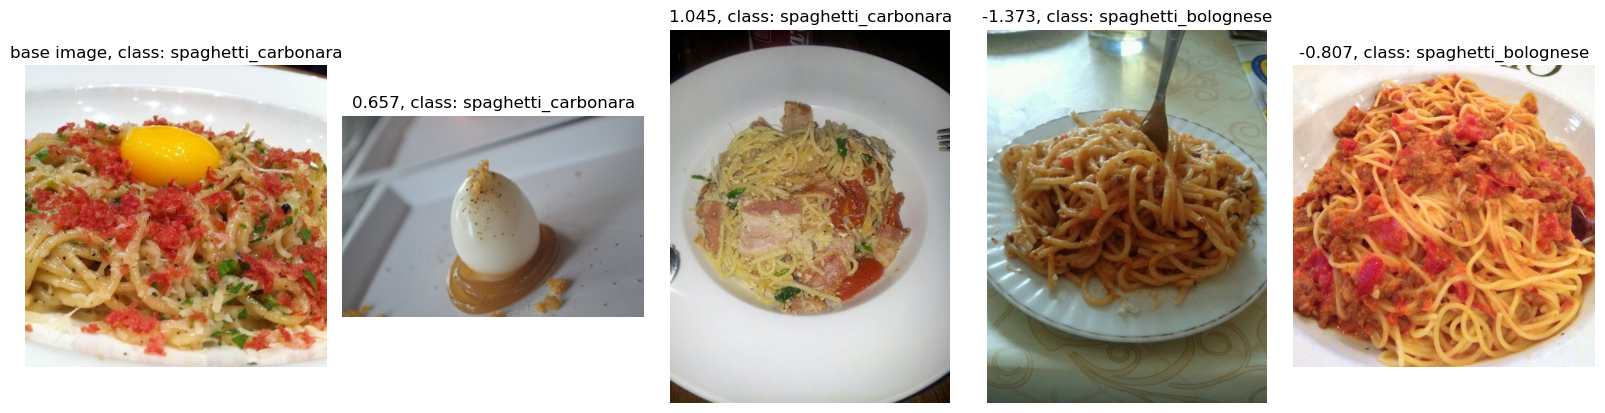

In [51]:
def plot_extreme_trak_examples_for_image(trak_scores, train_data, val_data, image_id, class_names):
    image_trak_scores = trak_scores.T[image_id]
    examples_indices_sorted_by_trak_scores = np.argsort(image_trak_scores)
    top_2_examples_indices = examples_indices_sorted_by_trak_scores[-2:]
    bottom_2_examples_indices = examples_indices_sorted_by_trak_scores[:2]
    base_image = val_data[image_id][0]
    # TODO ugly - needs refactoring
    plt.figure(figsize=(16, 12))
    plt.subplot(3, 5, 1)
    plt.imshow(base_image.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title(f"base image, class: {class_names[val_data[image_id][1]]}")
    for i, example_index in enumerate(top_2_examples_indices):
        image = train_data[example_index][0]
        score = image_trak_scores[example_index]
        plt.subplot(3, 5, i + 2)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.title(f"{score:.3f}, class: {class_names[train_data[example_index][1]]}")
    for i, example_index in enumerate(bottom_2_examples_indices):
        image = train_data[example_index][0]
        score = image_trak_scores[example_index]
        plt.subplot(3, 5, i + 4)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        plt.title(f"{score:.3f}, class: {class_names[train_data[example_index][1]]}")
    plt.tight_layout()
    plt.show()


# TODO filtering dataset needs to be a function and we need to change the name of the dataset variables (no need for "filtered")
filtered_dataset_no_transform = ImageFolder("data/food-101/food-101/images", transform=transforms.ToTensor())
filtered_dataset_no_transform.classes = [filtered_dataset_no_transform.classes[i] for i in chosen_indices]
filtered_dataset_no_transform.class_to_idx = {k: i for i, k in enumerate(filtered_dataset_no_transform.classes)}
filtered_dataset_no_transform.samples = list(filter(lambda s: s[1] in chosen_indices, filtered_dataset_no_transform.samples))
filtered_dataset_no_transform.samples = list(map(lambda s: (s[0], new_class_idx_mapping[s[1]]), filtered_dataset_no_transform.samples))
filtered_train_subset_no_transform, filtered_test_subset_no_transform = torch.utils.data.random_split(filtered_dataset_no_transform, [0.8, 0.2], torch.Generator().manual_seed(42))

plot_extreme_trak_examples_for_image(test_scores, filtered_train_subset_no_transform, filtered_test_subset_no_transform, 6, filtered_dataset_no_transform.classes)

# reminder - some images have incorrect classes on purpose in this dataset
# like the second image on the plot for id 6

In [69]:
# the hope is that TRAK could help us in finding such images so that we could remove them
# let's examine the mislabeled image mentioned earlier

mislabeled_image_id = 4258

group_alignment_scores[group_alignment_scores >= group_alignment_scores[mislabeled_image_id]]

# the mislabeled image is the 7th most positively important example in the dataset, according to TRAK results - this should not be the case

array([0.19803796, 0.60690179, 0.42394996, 0.27022052, 0.1918269 ,
       0.21025534, 0.67643199])

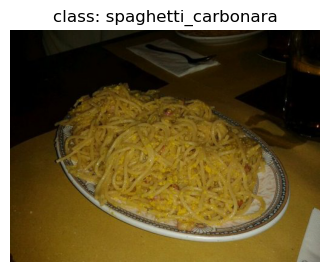

In [73]:
# let's examine the image (and its class), where the alignment score is the highest

top_alignment_image_id = np.argmax(group_alignment_scores)
top_alignment_image = filtered_train_subset_no_transform[top_alignment_image_id][0]
top_alignment_image_class = filtered_train_subset_no_transform[top_alignment_image_id][1]

# TODO should be a function
plt.figure(figsize=(4, 4))
plt.imshow(top_alignment_image.permute(1, 2, 0).cpu().numpy())
plt.title(f"class: {filtered_dataset_no_transform.classes[top_alignment_image_class]}")
plt.axis("off")
plt.show()

# hard to say what's unusual in this image

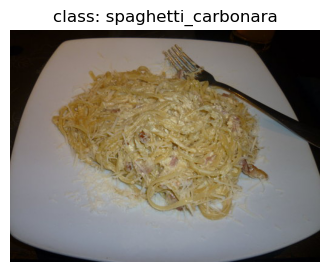

In [74]:
# let's examine the image with lowest score

bottom_alignment_image_id = np.argmin(group_alignment_scores)
bottom_alignment_image = filtered_train_subset_no_transform[bottom_alignment_image_id][0]
bottom_alignment_image_class = filtered_train_subset_no_transform[bottom_alignment_image_id][1]

plt.figure(figsize=(4, 4))
plt.imshow(bottom_alignment_image.permute(1, 2, 0).cpu().numpy())
plt.title(f"class: {filtered_dataset_no_transform.classes[bottom_alignment_image_class]}")
plt.axis("off")
plt.show()

# it's almost the same image as the one with the highest alignment score. it seems that spaghetti dishes have high variability in scores
# (also taking into account that egg image (mislabeled as spaghetti carbonara), which had many scores far from 0, not like other images)
# maybe the model is confused between spaghetti carbonara and bolognese

## Original class weights formula

In [77]:
# just to be sure, let's repeat the experiment with the original formula for computing class weights

def compute_class_weights_original_formula(preds, targets):
    class_weights = []
    for i in range(num_classes):
        n_elements = np.sum(targets == i)
        # no minus sign before sum here
        class_weights.append(np.exp(1 / n_elements * np.sum(np.log(preds[targets == i][:, i]))))
    return np.array(class_weights)

class_weights_orig = compute_class_weights_original_formula(preds, targets)
group_alignment_scores_orig = compute_class_alignment_scores(test_scores, targets, class_weights_orig)
sorted_group_alignment_scores_orig = np.sort(group_alignment_scores_orig)
example_indices_to_keep_orig = np.nonzero(~(group_alignment_scores_orig < sorted_group_alignment_scores_orig[top_k_to_remove]))[0]

100%|██████████| 8000/8000 [00:01<00:00, 6487.78it/s]


In [82]:
mislabeled_image_id = 4258

group_alignment_scores_orig[group_alignment_scores_orig >= group_alignment_scores_orig[mislabeled_image_id]], group_alignment_scores_orig[mislabeled_image_id]
# no significant difference

(array([0.19278098, 0.2596838 , 0.21289319, 0.15190724, 0.10242793,
        0.17135397]),
 0.10242792690863031)

## Opposite experiment - removing most positively impactful examples

In [93]:
# using changed formula for computing class weights
example_indices_to_keep_2 = np.nonzero(~(group_alignment_scores >= sorted_group_alignment_scores[len(group_alignment_scores) - top_k_to_remove]))[0]

train_data_after_trak_2 = torch.utils.data.Subset(filtered_train_subset, example_indices_to_keep)
train_dl_after_trak_2 = torch.utils.data.DataLoader(train_data_after_trak_2, batch_size=64, shuffle=True)

model_after_trak_2 = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")
model_after_trak_2.classifier = nn.Sequential(
                    nn.Flatten(start_dim=1, end_dim=-1),
                    nn.Linear(in_features=512, out_features=num_classes))
for param in model_after_trak_2.classifier.parameters():
        param.requires_grad = True
model_after_trak_2.num_labels = num_classes

In [94]:
num_epochs = 20
lr = 1e-4
optimizer = torch.optim.Adam(model_after_trak_2.parameters(), lr=lr)
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

# results after removing most positively impactful examples selected by TRAK - valid loss: 0.488, valid acc: 0.844
train_model(model_after_trak_2, train_dl_after_trak_2, test_dl, num_epochs, optimizer, early_stopping=early_stopping)

100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


[Epoch 1] Loss: 0.874, Train Acc: 0.714,Valid loss: 0.572 Valid Acc: 0.811


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


[Epoch 2] Loss: 0.266, Train Acc: 0.925,Valid loss: 0.517 Valid Acc: 0.825


100%|██████████| 32/32 [00:25<00:00,  1.27it/s]


[Epoch 3] Loss: 0.072, Train Acc: 0.991,Valid loss: 0.488 Valid Acc: 0.844


100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


[Epoch 4] Loss: 0.023, Train Acc: 0.999,Valid loss: 0.499 Valid Acc: 0.856


100%|██████████| 32/32 [00:22<00:00,  1.39it/s]


[Epoch 5] Loss: 0.011, Train Acc: 1.000,Valid loss: 0.514 Valid Acc: 0.841


100%|██████████| 32/32 [00:23<00:00,  1.34it/s]


[Epoch 6] Loss: 0.007, Train Acc: 1.000,Valid loss: 0.524 Valid Acc: 0.852
Early stopping at epoch 6


In [100]:
torch.save(model_after_trak_2.state_dict(), "model_after_trak_top_scores_removed.pth")

In [99]:
# the results actually improve, let's investigate this further.
# hypothesis - removing bottom k scores removes too much examples from one class (spaghetti carbonara?), thus making learning this class more difficult

removed_examples_indices = np.nonzero(group_alignment_scores < sorted_group_alignment_scores[top_k_to_remove])[0]
classes = []
for i in removed_examples_indices:
    classes.append(filtered_train_subset[i][1])
classes = np.array(classes)

for i in np.unique(classes):
    print(len(classes[classes == i]) / len(classes))

# hypothesis not true - the examples got removed close to uniformly

0.145
0.13
0.05
0.08
0.085
0.105
0.095
0.105
0.13
0.075


## Shortcut learning / simplicity bias

In [ ]:
# nothing we found in this regard - we found the results unintuitive (although model performance improved after removing examples with TRAK)

In [ ]:
# TODO
# write a few-page summary
# readme, installation documentation
# code cleanup